In [1]:
import networkx as nx
import numpy as np
import pandas as pd

In [2]:
import pandas as pd
import gspread
from gcloud import storage
from oauth2client.service_account import ServiceAccountCredentials

from google.cloud import storage
#pip install --upgrade google-cloud-storage. 
def upload_to_bucket(blob_name, path_to_file, bucket_name):
    """ Upload data to a bucket"""
     
    # Explicitly use service account credentials by specifying the private key
    # file.
    storage_client = storage.Client.from_service_account_json('service_account.json')

    #print(buckets = list(storage_client.list_buckets())

    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)
    blob.upload_from_filename(path_to_file)
    
    #returns a public url
    return blob.public_url

gc = gspread.service_account()

sh1 = gc.open('hc_dashboard_appdata')
worksheet = sh1.worksheet('ptrs_lats')

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# # Convert to a DataFrame and render.
ptrs_lats = pd.DataFrame.from_records(rows[1:])
ptrs_lats.columns = rows[0]

ptrs_lats = ptrs_lats.replace({'': 0})
ptrs_lats[ptrs_lats.columns[~ptrs_lats.columns.isin(['rpo_location', 'rpo_recruiting_group'])]] = \
ptrs_lats[ptrs_lats.columns[~ptrs_lats.columns.isin(['rpo_location', 'rpo_recruiting_group'])]].astype(float)
# storage_client = storage.Client.from_service_account_json('service_account.json')
# bucket = storage_client.get_bucket('hc_dashboard_ptrs_lats')
# blob = bucket.blob('updated_ptrs_lats')

In [3]:
def check_for_completeness(d): 
    """ checks for a complete path for """
    # d = ptrs_lats.loc[(ptrs_lats.rpo_location == l) & (ptrs_lats.rpo_recruiting_group == r)]

    # get ptrs
    m = d[d.index[d.index.str.startswith('ptr')]].replace({'' : 0}).astype(float)
    m = m.loc[m > 0].reset_index()
    
    # get rid of nans and 0s
    xy = m['index'].str.split('_')
    m['source'] = xy.str[1]
    m['target'] = xy.str[2]
    
    G = nx.DiGraph()
    G.add_edges_from(m[['source', 'target']].values)

    try: 
        return nx.has_path(G, 'ac', 'oa')
    except: 
        return False
    
ptrs_lats['has_complete_path'] = ptrs_lats.apply(check_for_completeness, axis = 1)

In [4]:
# check ptrs and lats for complete paths
ptrs_lats = ptrs_lats[ptrs_lats.apply(check_for_completeness, axis = 1)].assign(
    lookback_window = ptrs_lats.lookback_window.astype(int)
)

# get the earliest complete path
ptrs_lats['rnk'] = ptrs_lats.groupby(['rpo_location', 'rpo_recruiting_group']).lookback_window.rank()
ptrs_lats = ptrs_lats.loc[ptrs_lats.rnk == 1]

In [47]:
d = ptrs_lats.loc[(ptrs_lats.rpo_location == 'India') & (ptrs_lats.rpo_recruiting_group == 'India SWE Recruiting')]
d = d.melt(id_vars = ['rpo_location', 'rpo_recruiting_group'])
d_ptr = d.loc[d.variable.str.startswith('ptr')]
xy = d_ptr['variable'].str.split('_')
d_ptr = d_ptr.assign(
    x = xy.str[1],
    y = xy.str[2]
)

G = nx.Graph()
G.add_edges_from(d_ptr[['x', 'y']].values)

d_ptr_dic = {}
for i, r in d_ptr[['x', 'y', 'value']].iterrows(): 
    d_ptr_dic[(r['x'], r['y'])] = np.log(r['value'])

nx.set_edge_attributes(G, values = d_ptr_dic, name = 'weight')


#[d.columns[d.columns.str.startswith('ptr') | d.columns.str.startswith('lat')]], 

In [48]:
d_ptr_dic = {}
d_ptr.apply(lambda row : d_ptr_dic[(row['x'], row['y'])] = row['value'], axis = 1)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (1951786460.py, line 2)

In [105]:
oa_goal = 200

Paths = []
path_weights = []
for path in nx.all_simple_paths(G, 'oa', 'ac', cutoff=None): 
    Paths.append(path)
    path_weights.append(np.exp(nx.path_weight(G, path, 'weight')))
path_weights = np.array(path_weights)    
normalized_path_weights = path_weights / np.sum(path_weights)

for p, w in zip(Paths, normalized_path_weights): 
    mini_path = p
    individual_oa_goal = np.ceil(w * 200)
    print(mini_path)
    goal = individual_oa_goal
    print('oa', goal)
    for x, y in zip(mini_path[:-1], mini_path[1:]): 
        pt = np.exp(G.edges[y, x]['weight'])
        goal = np.ceil(goal / pt)
        print(y, goal, pt)

['oa', 'oe', 'os', 'ac']
oa 42.0
oe 47.0 0.90541
os 895.0 0.05254000000000002
ac 71888.0 0.012449999999999996
['oa', 'oe', 'os', 'pi', 'ac']
oa 40.0
oe 45.0 0.90541
os 857.0 0.05254000000000002
pi 4532.0 0.18912
ac 71540.0 0.06335
['oa', 'oe', 'hc', 'os', 'ac']
oa 61.0
oe 68.0 0.90541
hc 140.0 0.48889
os 883.0 0.15873
ac 70924.0 0.012449999999999996
['oa', 'oe', 'hc', 'os', 'pi', 'ac']
oa 59.0
oe 66.0 0.90541
hc 135.0 0.48889
os 851.0 0.15873
pi 4500.0 0.18912
ac 71034.0 0.06335


In [93]:
np.exp(G.edges['oe', 'oa']['weight'])

0.90541

In [41]:
def recurse_through_graph(G, x = 'oa'): 
    y = G[x]
recurse_through_graph(G)

y = G['oa']
y

AtlasView({})

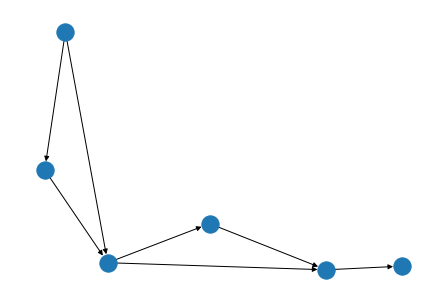

In [42]:
nx.draw(G)

In [3]:
def edge_list(d): 
    d2 = pd.DataFrame(d1)
    v2 = d2.variable.str.split("_")

    d2 = d2.assign(
        stat = v2
    )

    d2['x'] = d2.stat.str[0]
    d2['y'] = d2.stat.str[1]
    d3 = d2.groupby(['x', 'y']).apply(lambda g : g['value'].values)

    d3.name = 'stats'
    d3 = d3.reset_index()

    ac_oa_ptr = d2[d2.variable.str.endswith('ptr')]['value'].prod()
    ac_oa_lat = d2[d2.variable.str.endswith('lat')]['value'].sum()

    pi_oa_ptr = d2[(d2.variable.str.endswith('ptr')) & ~(d2.variable.str.contains('ac'))]['value'].prod()
    pi_oa_lat = d2[(d2.variable.str.endswith('lat')) & ~(d2.variable.str.contains('ac'))]['value'].sum()

    os_oa_ptr = d2[(d2.variable.str.endswith('ptr')) & ~(d2.variable.str.contains('ac|pi'))]['value'].prod()
    os_oa_lat = d2[(d2.variable.str.endswith('lat')) & ~(d2.variable.str.contains('ac|pi'))]['value'].sum()

    oe_oa_ptr = d2[(d2.variable.str.endswith('ptr')) & ~(d2.variable.str.contains('ac|pi|os'))]['value'].prod()
    oe_oa_lat = d2[(d2.variable.str.endswith('lat')) & ~(d2.variable.str.contains('ac|pi|os'))]['value'].sum()

    ac_ppr = (d2[d2.variable == 'ppr']['value'] / ac_oa_ptr).values[0] / 4.6


,rpo_location,rpo_recruiting_group,ptr_ac_pi,ptr_ac_os,ptr_pi_os,ptr_os_hc,ptr_os_oe,ptr_hc_oe,ptr_oe_oa,lat_ac_pi,lat_ac_os,lat_pi_os,lat_os_hc,lat_os_oe,lat_hc_oe,lat_oe_oa
0,India,APAC Intern Recruiting,0,0.49053,,0.07436,0.01318,0.0641,0,,28.13653,,7.30769,18.84615,7.2,
1,India,APAC-Horizontals-SWE-Recruiting-RSR,0.24324,0.09016,0.07407,0.15385,0,1,0.5,17.14815,66.63636,9.5,,,14.5,1
2,India,GBO Recruiting,0,0,,,,,,,,,,,,
3,India,India Cloud Recruiting,0.02194,0.18275,0.42857,0.04072,0.02242,0.44444,0.88889,16.85714,20.79439,8.66667,20.44444,11.5,2.66667,2
4,India,India GBO Recruiting,0,0.3945,,0,0,,,,6.04651,,,,,
5,India,India SWE Recruiting,0.06423,0.01226,0.19016,0.16405,0.05546,0.52128,0.90123,44.09761,37.5189,42.42308,112.86076,202.25,47,1.69333
6,LATAM,GBO Recruiting,0,0.00402,,0.02222,0.06383,1,1,,18.04255,,34,12,0,1.5
7,US,Cloud Americas Recruiting,0.00781,0.25665,0.42105,0.04289,0.08255,0.88571,0.85149,27.15789,22.05119,7.25,31.04167,31.23333,7.36667,1.86517
8,US,Early Career SWE Recruiting,0,0,,,,,,,,,,,,
9,US,GBO Recruiting,0.09994,0.07307,0.41615,0.0274,0.28866,1,0.9,11,15.51181,5.56716,41.25,9.75,38,0.92727


In [195]:
pipeline = pd.read_csv('gs://hc_dashboard_ptrs_lats/app_data/curr_in_progress.csv',
                       storage_options={"token": "utils/service_account.json"})

/var/folders/mn/llyzbhpx6x91l387r0kfsz2w00x9tq/T/ipykernel_47627/3566413053.py:1: DtypeWarning: Columns (142,144,174,182,190) have mixed types. Specify dtype option on import or set low_memory=False.
  pipeline = pd.read_csv('gs://hc_dashboard_ptrs_lats/app_data/curr_in_progress.csv',


In [196]:
candidates_in_progress = pd.read_csv('in_progress_pipeline.csv')

In [197]:
candidates_in_progress

,Unnamed: 0,rpo_group,application_create_week,phone_interview,onsite_interview,offer_extended,offer_accepted,current_outcome,application_closed_week,N,n_weeks,candidate_pid
0,0,India SWE Recruiting,2023-05-07,6.0,NaN,NaN,NaN,IN_PROGRESS,9,1,[0 1 2 3 4 5 6 7 8 9],d78a2dd113ad241b
1,8,India SWE Recruiting,2023-06-25,NaN,NaN,NaN,NaN,IN_PROGRESS,2,1,[0 1 2],0d817806b4de6081
2,10,India SWE Recruiting,2022-06-26,6.0,8.0,NaN,NaN,IN_PROGRESS,29,1,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,06c7e8efd9b19987
3,11,India SWE Recruiting,2023-07-09,6.0,NaN,NaN,NaN,IN_PROGRESS,0,1,[0],b186159ad3ac550a
4,13,India SWE Recruiting,2022-06-26,3.0,5.0,NaN,NaN,IN_PROGRESS,17,1,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,8b301fe03c0f77e2
...,...,...,...,...,...,...,...,...,...,...,...,...
196,753,India SWE Recruiting,2023-07-09,8.0,NaN,NaN,NaN,IN_PROGRESS,0,1,[0],45acb0db42d29dd1
197,756,India SWE Recruiting,2022-07-24,NaN,5.0,NaN,NaN,IN_PROGRESS,26,1,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,bbdedc420c39c70b
198,758,India SWE Recruiting,2022-03-20,NaN,10.0,NaN,NaN,IN_PROGRESS,46,1,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,06cd75f6f7e52ed4
199,760,India SWE Recruiting,2023-06-25,NaN,NaN,NaN,NaN,IN_PROGRESS,1,1,[0 1],16551bb52cb16d29
